# Calibration
inspired by: http://jasss.soc.surrey.ac.uk/17/3/11.html

In [1]:
%matplotlib inline
import math
import numpy as np
import numpy.random as nrand
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import scipy.stats as stats
import powerlaw
from stockmarket import baselinemodel
from tqdm import tqdm
from pandas_datareader import data
from pylab import plot, show
from math import isclose
from stockmarket.stylizedfacts import *
import itertools
import quandl

In [5]:
print (np.__version__)

1.12.0


# Import SPY data

### Prices

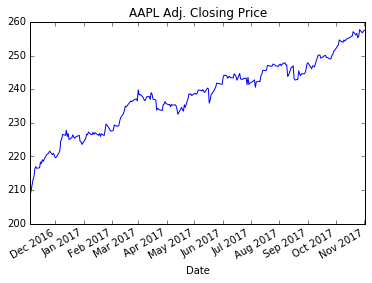

In [3]:
start_date = '2010-01-01'
end_date = '2016-12-31'

spy = data.DataReader("SPY", 
                       start=start_date, 
                       end=end_date, 
                       data_source='google')['Close']

spy.plot(title='AAPL Adj. Closing Price')

### Returns

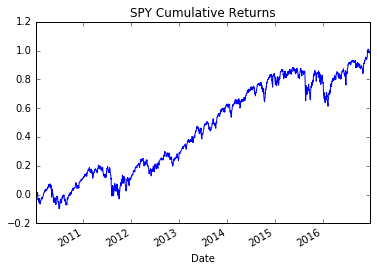

In [3]:
returns = spy.pct_change()
((1 + returns).cumprod() - 1).plot(title='SPY Cumulative Returns')

In [4]:
len(returns)

1761

### Price to earnings

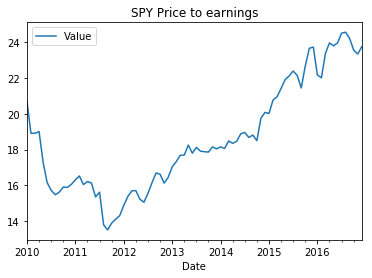

In [5]:
price_to_earning = quandl.get("MULTPL/SP500_PE_RATIO_MONTH", authtoken="8EKNms1cLLU-dBjk5Y4d").loc[start_date:end_date]
price_to_earning.plot(title='SPY Price to earnings')

## Calibrate agent_price_to_earnings_window with S&P 500 data

In [6]:
init_price_to_earnings_window = {}
price_to_earnings_descriptives = price_to_earning.describe()
init_price_to_earnings_window['lower_min'] = int(price_to_earnings_descriptives.loc['min']['Value'])
init_price_to_earnings_window['upper_min'] = int(price_to_earnings_descriptives.loc['25%']['Value'])

init_price_to_earnings_window['lower_max'] = int(price_to_earnings_descriptives.loc['75%']['Value'])
init_price_to_earnings_window['upper_max'] = int(price_to_earnings_descriptives.loc['max']['Value'])

init_price_to_earnings_window

{'lower_max': 21, 'lower_min': 13, 'upper_max': 24, 'upper_min': 16}

# 1 Calibrate zero intelligence benchmark to S&P 500 data

First we determine the value of money, initial profit and the discount rate by minimising the distance to the price to average price to earnings ratio observed in the S&P 500. 

| Parameter | Values |
| -------------| ------------|
| initial_total_money       | 13000 - 23000       |
| initial_profit       | 1000 - 10000    |
| discount_rate       | 0.01 - 0.25       |


$pricetoearningscriteria(x)=\left\{\begin{array}{cl}(\frac{av - x}{av})^2 & \quad \textrm{if} \quad\  lowerx < x < upperx,\\
\infty &\quad \textrm{otherwise}\quad\\\
\end{array}\right.,$

In [28]:
# Full factorial design for: 
initial_total_money = [x for x in range(26000, 33000, 2000)]
initial_profit = [x for x in range(1000, 10000, 2000)]
discount_rate = [x / 100 for x in range(1, 25, 2)]
factors = list(itertools.product(initial_total_money, initial_profit, discount_rate))

In [9]:
len(factors)

240

In [10]:
# calculate the observed price to earnings
observed_average_price_to_earnings = price_to_earnings_descriptives.loc['mean']['Value']
observed_average_price_to_earnings

18.598928571428576

In [51]:
def calcute_cost(average_price_to_earnings, upper_bound, lower_bound, observed_average):
    """cost function for deviation from observed price to earnings ratio"""
    if (average_price_to_earnings < upper_bound) and (average_price_to_earnings > lower_bound):
        return ((observed_average - average_price_to_earnings) / observed_average)**2
    else:
        return np.inf

In [55]:
results = {}
# for every parameter possibility:
for idx, parameters in tqdm(enumerate(factors)):
    # 1 simulate model
    agents, firms, stocks, order_books = baselinemodel.stockMarketSimulation(seed=0,
                                                                             simulation_time=100,
                                                                         init_backward_simulated_time=200,
                                                                         number_of_agents=1000,
                                                                         share_chartists=0.0,
                                                                         share_mean_reversion=0.5,
                                                                         amount_of_firms=1,
                                                                         initial_total_money=(parameters[0],parameters[0]*1.1),
                                                                         initial_profit=(parameters[1], parameters[1]),
                                                                         discount_rate=parameters[2],
                                                                         init_price_to_earnings_window=((init_price_to_earnings_window['lower_min'],
                                                                                                         init_price_to_earnings_window['upper_min']),
                                                                                                        (init_price_to_earnings_window['lower_max'] ,
                                                                                                         init_price_to_earnings_window['upper_max'])),
                                                                         order_expiration_time=200,
                                                                         agent_order_price_variability=(1,1),
                                                                         agent_order_variability=1.5,
                                                                         agent_ma_short=(20, 40),
                                                                         agent_ma_long=(120, 150),
                                                                         agents_hold_thresholds=(0.9995, 1.0005),
                                                                         agent_volume_risk_aversion=0.1,
                                                                         agent_propensity_to_switch=1.1,
                                                                         firm_profit_mu=0.058,
                                                                         firm_profit_delta=0.00396825396,
                                                                         firm_profit_sigma=0.125,
                                                                         profit_announcement_working_days=20,
                                                                         printProgress=False,
                                                                         )
    # 2 extract average price to earnings ratio
    average_price_to_earnings = np.mean(stocks[0].price_to_earnings_history)
    # 3 calculate costs
    cost = calcute_cost(average_price_to_earnings, 
                        init_price_to_earnings_window['lower_max'], 
                        init_price_to_earnings_window['upper_min'],
                        observed_average_price_to_earnings)
    # 4 save costs with parameter pair 
    results[str(idx)] = (cost, average_price_to_earnings)

240it [44:38, 10.67s/it]


## Find the smallest error

In [64]:
calibrated_parameters_location = min(non_zero_results, key=non_zero_results.get)

# The parameter values are:

In [55]:
#parameters = factors[int(calibrated_parameters_location)]
backward_simulated_time = 400
initial_total_money = 26000
init_profit = 1000
init_discount_rate = 0.17

# 2 Calibration with stylized facts


### Constrained parameters
Then, we determine the value of the remaining parameters

| Parameter | Values |
| -------------| ------------|
| share_chartists       | 0 - 1, 0.1      |
| share_mean_reversion       | 0 - 1, 0.1   |
| order_expiration_time       | 1000 - 10000, 1000      |
| agent_order_price_variability       | 1 - 10, 1      |
| agent_order_variability       | 0.1 - 5       |
| agent_ma_short       | 5 - 100, 5      |
| agent_ma_long       | 50 - 400, 50      |
| agents_hold_thresholds       | 0.0005        |
| Agent_volume_risk_aversion       | 0.1 - 1, 0.1      |
| Agent_propensity_to_switch       | 0.1 - 2.2, 0.1      |
| profit_announcement_working_days       | 5 - 50, 5       |
| price_to_earnings_spread       | 5 - 50, 5       |
| price_to_earnings_heterogeneity       | 5 - 50, 5       |

## Parameter sampling using latin hypercube sampling

extra parameters: 

* price to earnings base (lowest value) --> [10,20] 
* price to earnings heterogeneity lowPE * price to earnings heterogeneity = highPE --> [1.1,2.5]
* price to earnings gap (high-low + gap = low_high) --> int([4,20]) 
* price longMA window heterogeneity (high longMA = heterogeneity*lowlongMA)  --> [1.1,1.8]
* price shortMA window heterogeneity (high shortMA = heterogeneity*shortlongMA) --> [1.1,1.8]
* shortMA memory divider --> int()

In [56]:
problem = {
  'num_vars': 17,
  'names': ['share_chartists', 'share_mean_reversion', 'order_expiration_time', 'agent_order_price_variability', 
            'agent_order_variability', 'agent_ma_short', 'agent_ma_long', 'agents_hold_thresholds',
           'agent_volume_risk_aversion', 'agent_propensity_to_switch', 'profit_announcement_working_days',
           'price_to_earnings_base', 'price_to_earnings_heterogeneity', 'price_to_earnings_gap',
           'longMA_heterogeneity', 'shortMA_heterogeneity', 'shortMA_memory_divider'],
  'bounds': [[0, 1], [0, 1], [1000, 10000], [1, 10], 
             [0.1, 5.0], [5, 100], [50, 400], [0.00005,0.01], 
             [0.1, 1], [0.1, 2.2], [5, 50],
             [10,20], [1.1,2.5], [4,20],
             [1.1,1.8], [1.1,1.8], [1, 10]]
}

In [57]:
from SALib.sample import latin

In [58]:
latin_hyper_cube = latin.sample(problem=problem, N=500) # N is the amount of combinations or in the this case amount of simulations

In [59]:
latin_hyper_cube[1][11]

17.594688777900814

In [16]:
# insert latin hypercube sample into parameter
share_chartists= latin_hyper_cube[0][0]
share_mean_reversion = latin_hyper_cube[0][1]
order_expiration_time = int(latin_hyper_cube[0][2])
agent_order_price_variability = int(latin_hyper_cube[0][3])
agent_order_variability = int(latin_hyper_cube[0][4])
agent_ma_short = int(latin_hyper_cube[0][5])
agent_ma_long = int(latin_hyper_cube[0][6])
agents_hold_thresholds = latin_hyper_cube[0][7]
agent_volume_risk_aversion = latin_hyper_cube[0][8]
agent_propensity_to_switch = latin_hyper_cube[0][9]
profit_announcement_working_days = int(latin_hyper_cube[0][10])
price_to_earnings_base = int(latin_hyper_cube[0][11])
price_to_earnings_heterogeneity = latin_hyper_cube[0][12]
price_to_earnings_gap = int(latin_hyper_cube[0][13])
longMA_heterogeneity = latin_hyper_cube[0][14]
shortMA_heterogeneity = latin_hyper_cube[0][15]
shortMA_memory_divider = latin_hyper_cube[0][16]

In [19]:
int(latin_hyper_cube[0][11])

17

### Fitness criteria

$zeroAutocorrelation(w)=\left\{\begin{array}{cl}(\frac{spy(w) - w}{spy(w)})^2 & \quad \textrm{if} \quad\  lowerw < w < upperw,\\
\infty &\quad \textrm{otherwise}\quad\\\
\end{array}\right.,$

$fat Tails(x)=\left\{\begin{array}{cl}(\frac{spy(x) - x}{spy(x)})^2 & \quad \textrm{if} \quad\  lowerx < x < upperx,\\
\infty &\quad \textrm{otherwise}\quad\\\
\end{array}\right.,$

$clustered Volatility(y)=\left\{\begin{array}{cl}(\frac{spy(y) - y}{spy(y)})^2 & \quad \textrm{if} \quad\  lowery < y < uppery,\\
\infty &\quad \textrm{otherwise}\quad\\\
\end{array}\right.,$

$long Memory(z)=\left\{\begin{array}{cl}(\frac{spy(z) - z}{spy(z)})^2 & \quad \textrm{if} \quad\  lowerz < z < upperz,\\
\infty &\quad \textrm{otherwise}\quad\\\
\end{array}\right.,$

$cost(w,x,y,z)= zeroAutocorrelation(w) + fat Tails(x) + clustered Volatility(y) + long Memory(z) \quad \textrm{if} \quad\ 
\{w,x,y,z\} < \infty
$

# Calibration to SPY values


Perhaps add 1 to all returns and see what that does to the powerlaw function:

In [ ]:
import json

In [60]:
results = {}
# for every parameter possibility:
for idx, parameters in tqdm(enumerate(latin_hyper_cube)):
    # 1 simulate model
    # insert latin hypercube sample into parameter
    share_chartists= parameters[0]
    share_mean_reversion = parameters[1]
    order_expiration_time = int(parameters[2])
    agent_order_price_variability = int(parameters[3])
    agent_order_variability = parameters[4]
    agent_ma_short = int(parameters[5])
    agent_ma_long = int(parameters[6])
    agents_hold_thresholds = parameters[7]
    agent_volume_risk_aversion = parameters[8]
    agent_propensity_to_switch = parameters[9]
    profit_announcement_working_days = int(parameters[10])
    price_to_earnings_base = int(parameters[11])
    price_to_earnings_heterogeneity = parameters[12]
    price_to_earnings_gap = int(parameters[13])
    longMA_heterogeneity = parameters[14]
    shortMA_heterogeneity = parameters[15]
    shortMA_memory_divider = parameters[16]
    
    PE_low_low = price_to_earnings_base
    PE_low_high = int(price_to_earnings_heterogeneity*price_to_earnings_base)
    PE_high_low = PE_low_high + price_to_earnings_gap
    PE_high_high = int(price_to_earnings_heterogeneity*PE_high_low)
    #print('PE ratios are: ', PE_low_low, PE_low_high, PE_high_low, PE_high_high)
    
    # simulate the model 
    agents, firms, stocks, order_books = baselinemodel.stockMarketSimulation(seed=0,
                                                                             simulation_time=200,
                                                                         init_backward_simulated_time=int(agent_ma_long*longMA_heterogeneity),
                                                                         number_of_agents=1000,
                                                                         share_chartists=share_chartists,
                                                                         share_mean_reversion=share_mean_reversion,
                                                                         amount_of_firms=1,
                                                                         initial_total_money=(initial_total_money,int(initial_total_money*1.1)),
                                                                         initial_profit=(init_profit, init_profit),
                                                                         discount_rate=init_discount_rate,
                                                                         init_price_to_earnings_window=((PE_low_low,
                                                                                                         PE_low_high),
                                                                                                        (PE_high_low,
                                                                                                         PE_high_high)),
                                                                         order_expiration_time=order_expiration_time,
                                                                         agent_order_price_variability=(agent_order_price_variability,agent_order_price_variability),
                                                                         agent_order_variability=agent_order_variability,
                                                                         agent_ma_short=(agent_ma_short, int(agent_ma_short*shortMA_heterogeneity)),
                                                                         agent_ma_long=(agent_ma_long, int(agent_ma_long*longMA_heterogeneity)),
                                                                         agents_hold_thresholds=(1-agents_hold_thresholds, 1+agents_hold_thresholds),
                                                                         agent_volume_risk_aversion=agent_volume_risk_aversion,
                                                                         agent_propensity_to_switch=agent_propensity_to_switch,
                                                                         firm_profit_mu=0.058,
                                                                         firm_profit_delta=0.00396825396,
                                                                         firm_profit_sigma=0.125,
                                                                         profit_announcement_working_days=profit_announcement_working_days,
                                                                             mean_reversion_memory_divider=4,
                                                                         printProgress=False,
                                                                         )
    # Apply the tests 
    # apply all tests to the model 
    # test 1
    first_test = zero_autocorrelation(calculate_returns(order_books[0].transaction_prices_history), 25)
    # test 2
    second_test = fat_tails_kurtosis(calculate_returns(order_books[0].transaction_prices_history))#fat_tails(calculate_returns(order_books[0].transaction_prices_history))
    # test 3
    third_test = clustered_volatility(calculate_returns(order_books[0].transaction_prices_history), 25)
    # test 4
    fourth_test = long_memory(calculate_returns(order_books[0].transaction_prices_history), hurst, 2, 20)
    # save parameter space and test results
    results[idx] = [first_test, second_test, third_test, fourth_test]

#store results in json file    
with open('result.json', 'w') as fp:
    json.dump(results, fp)
# store succesfull results in another json file
passed_results = {}
for key in results:
    passed_all_tests = []
    for element in results[key]:
        #print (element)
        passed_all_tests.append(element[0])
    if not False in passed_all_tests:
        passed_results[key] = results[key]

with open('passed_results.json', 'w') as fp:
    json.dump(passed_results, fp)

500it [5:36:46, 39.50s/it]


In [69]:
# store the succesful parameters in a file
succesfull_parameters = {}
for key in passed_results:
    succesfull_parameters[key] = list(latin_hyper_cube[key])
with open('succesfull_parameters.json', 'w') as fp:
    json.dump(succesfull_parameters, fp)

## Measure stylized facts in observed data

In [16]:
observed_autocorrelation = zero_autocorrelation(returns[200:], 25)[1]
observed_tail_fatness = returns[200:].kurtosis()
observed_volatility_clusterdness = clustered_volatility(returns[200:], 25)[1]
observed_long_memory = long_memory(returns[200:], hurst, 2, 20)[1]

In [17]:
observed_long_memory

-0.002499728651409917

In [88]:
observed_values = [observed_autocorrelation, observed_tail_fatness, observed_volatility_clusterdness, observed_long_memory]

In [83]:
def cost_calibration_two(observed_values, simulated_values):
    """cost function"""
    score = 0
    for obs, sim in zip(observed_values, simulated_values):
        score += ((obs - sim) / obs)**2
    return score

In [91]:
fit = {}
for key in passed_results: 
    #print(passed_results[key])
    sim_values = []
    for val in passed_results[key]:
        sim_values.append(val[1])
    cost = cost_calibration_two(observed_values, sim_values)
    fit[key] = cost
fit

{65: 64.990856718758764,
 98: 1044.2677329273547,
 451: 247.24091905640847,
 467: 364.18812511664964}

In [102]:
# change certain parameters to int
should_be_int = [2,3,5,6,10,11,13]

In [105]:
calibrated_parameters = succesfull_parameters[min(fit, key=fit.get)]
calibrated_parameters
for integer in should_be_int:
    #print(int(calibrated_parameters[integer]))
    calibrated_parameters[integer] = int(calibrated_parameters[integer])
    
calibrated_parameters

[0.63602194523175426,
 0.33808629077377589,
 6791,
 2,
 0.41645196996101297,
 50,
 65,
 0.0097878688431121148,
 0.15710589508611844,
 1.8790371901143861,
 13,
 11,
 1.2809853358963714,
 11,
 1.4419868801301829,
 1.204473734660668,
 3.539424126160756]

In [106]:
nameParam = {}
for name, parameter in zip(problem['names'], calibrated_parameters):
    nameParam[name] = parameter
nameParam

{'agent_ma_long': 65,
 'agent_ma_short': 50,
 'agent_order_price_variability': 2,
 'agent_order_variability': 0.41645196996101297,
 'agent_propensity_to_switch': 1.8790371901143861,
 'agent_volume_risk_aversion': 0.15710589508611844,
 'agents_hold_thresholds': 0.0097878688431121148,
 'longMA_heterogeneity': 1.4419868801301829,
 'order_expiration_time': 6791,
 'price_to_earnings_base': 11,
 'price_to_earnings_gap': 11,
 'price_to_earnings_heterogeneity': 1.2809853358963714,
 'profit_announcement_working_days': 13,
 'share_chartists': 0.63602194523175426,
 'share_mean_reversion': 0.33808629077377589,
 'shortMA_heterogeneity': 1.204473734660668,
 'shortMA_memory_divider': 3.539424126160756}

In [107]:
with open('calibrated_parameters.json', 'w') as fp:
    json.dump(nameParam, fp)